<a href="https://colab.research.google.com/github/AtsushiNi/myLeprecon/blob/master/niihama/plasma_data_12_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要
露光時間が短すぎてデータが綺麗に撮れなかったと判明<br>
露光時間を7秒に増やしてプラズマを撮った<br>
とりあえず感度校正は後回し

In [148]:
!pip install git+https://github.com/fujiisoup/pyspectra.git
!pip install netCDF4

import os
from os.path import join
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyspectra
import pandas as pd
import math
from scipy import interpolate
from scipy import integrate

  Cloning https://github.com/fujiisoup/pyspectra.git to /tmp/pip-req-build-8qok6zxi
  Running command git clone -q https://github.com/fujiisoup/pyspectra.git /tmp/pip-req-build-8qok6zxi
  Created wheel for pyspectra: filename=pyspectra-0.0.1-cp36-none-any.whl size=18787 sha256=6cfd0ecc475bbc8440d079ec9df86f594ff397d9361347eceed0329c9f45342e
  Stored in directory: /tmp/pip-ephem-wheel-cache-ujovem0o/wheels/a7/c4/4a/152e6df7ccc3c6838abee31c086e30a3690c80966eb588e7a2
Successfully built pyspectra


In [149]:
data_path = '/content/drive/MyDrive/研究室/myLeprecon/SpectrometerData/20201217_niihama'
print(os.path.exists(data_path))

True


In [150]:
file_names = [f'H_{430000 + 5000*i}.nc' for i in range(8)]
data = []
for file_name in file_names:
    data_array = xr.open_dataarray(join(data_path, file_name))
    data_array['motor_coordinate'] = data_array.attrs['motor_coordinate']
    data_array['exposure'] = data_array.attrs['exposure']
    data.append(data_array)
data = xr.concat(data, dim='motor_coordinate')

plasma_data = []
for i, p in enumerate(data['motor_coordinate']):
  d = data.sel(motor_coordinate=p).copy()
  d['long_x'] = d['x'][::-1] - 1000 * i
  d['x'] = data['x']
  plasma_data.append(d.sum('y'))
plasma_data = xr.concat(plasma_data, dim='motor_coordinate')

In [151]:
file_names = [f'back_{430000 + 5000*i}.nc' for i in range(8)]
data = []
for file_name in file_names:
    data_array = xr.open_dataarray(join(data_path, file_name))
    data_array['motor_coordinate'] = data_array.attrs['motor_coordinate']
    data_array['exposure'] = data_array.attrs['exposure']
    data.append(data_array)
data = xr.concat(data, dim='motor_coordinate')

back_data = []
for i, p in enumerate(data['motor_coordinate']):
    d = data.sel(motor_coordinate=p).copy()
    d['long_x'] = d['x'][::-1] - 1000 * i
    d['x'] = data['x']
    back_data.append(d.sum('y'))
back_data = xr.concat(back_data, dim='motor_coordinate')

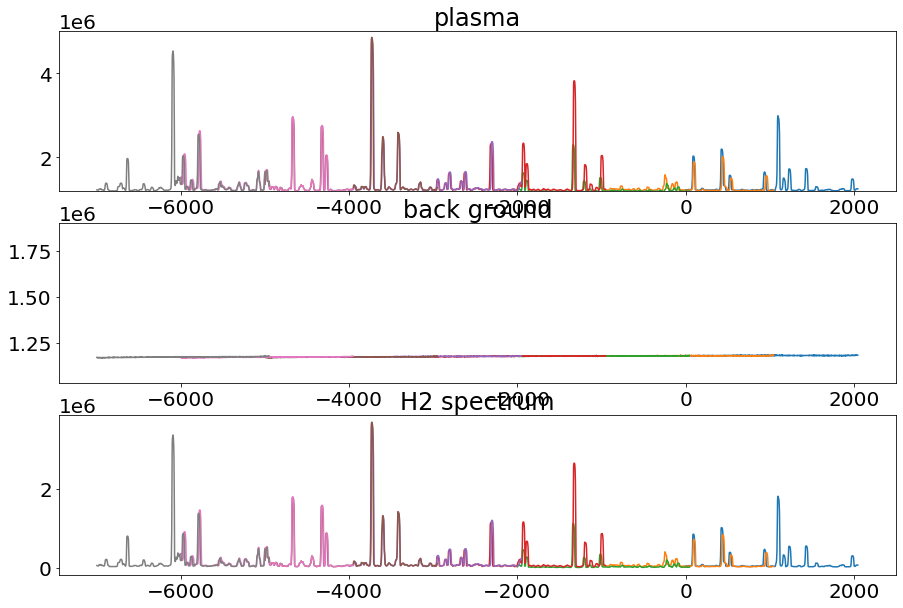

In [152]:
spectrum_data = plasma_data - back_data * 1.0

plt.figure(figsize=[15, 10])
plt.subplot(3, 1, 1)
plt.ylim(1.2*1e6, 5*1e6)
plt.title('plasma')
for f in plasma_data:
  plt.plot(f['long_x'], f)

plt.subplot(3, 1, 2)
plt.title('back ground')
plt.ylim(1.03*1e6, 1.9*1e6)
for f in back_data:
  plt.plot(f['long_x'], f)

plt.subplot(3, 1, 3)
plt.title('H2 spectrum')
for f in spectrum_data:
  plt.plot(f['long_x'], f)

# 波長校正

In [153]:
def fit(da):
  popt, perr = pyspectra.fit.singlepeak_fit(da['x'].values, da.values)
  return xr.Dataset({
      'A': popt[0], 'x0': popt[1], 'w': popt[2], 'y0': popt[3],
      'data': da,
      'fit': ('x', pyspectra.profiles.Gauss(da['x'].values, *popt))},
      coords={'x': da['x']})

## (v' - v") = (0 - 0)

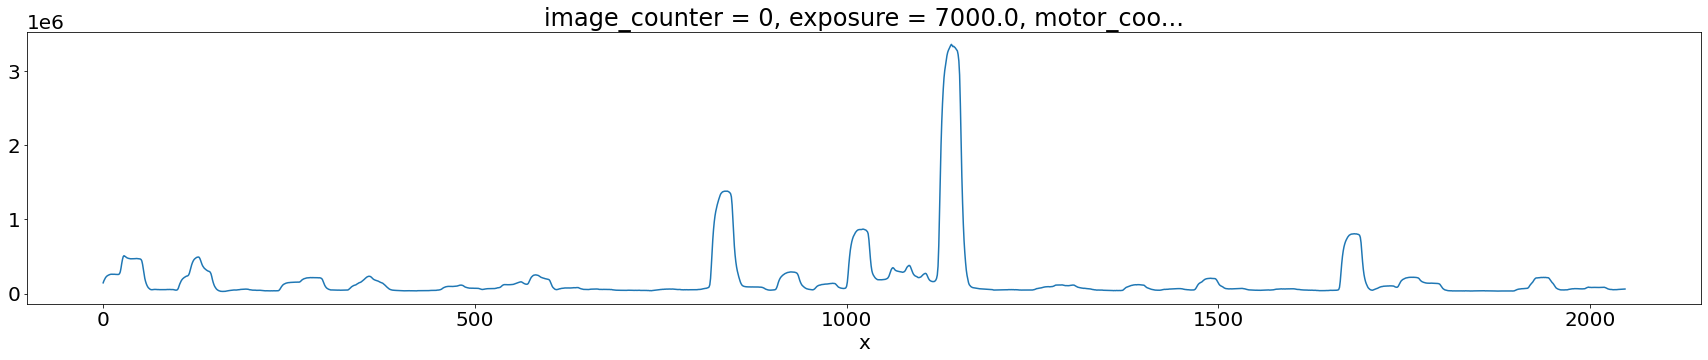

In [154]:
plt.figure(figsize=(30, 5))
spectrum_data.sel(motor_coordinate=465000).plot()
#plt.xlim(210, 310)
#plt.ylim(0, 400000)

Text(0, 0.5, 'wave length (nm)')

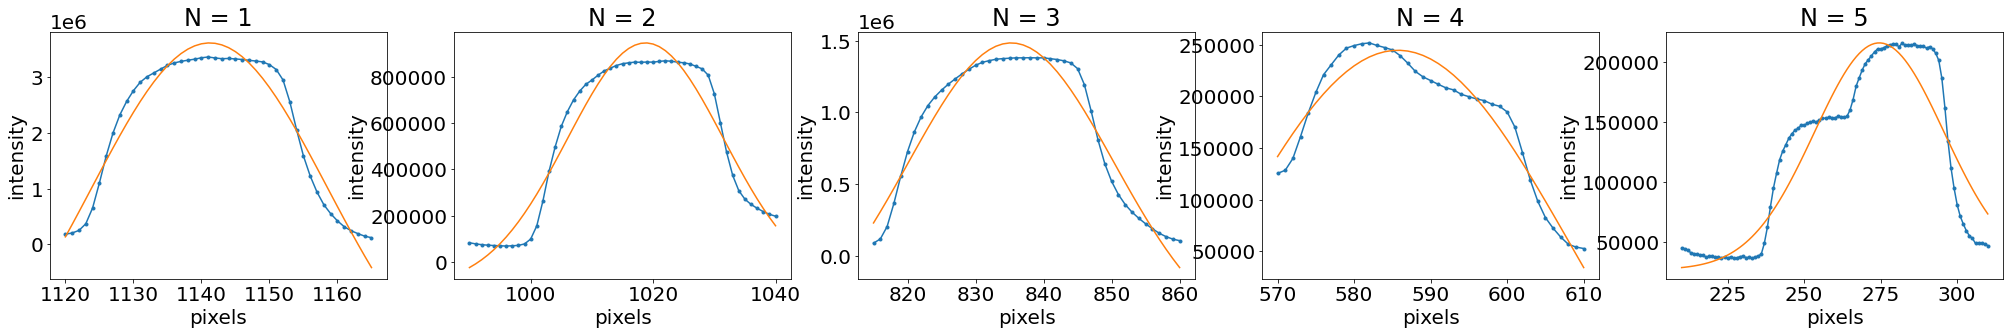

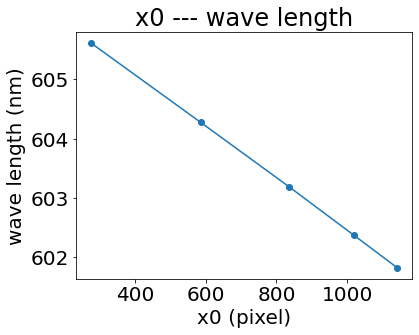

In [155]:
spectrum_lims = [
  [1120, 1165],
  [990, 1040],
  [815, 860],
  [570, 610],
  [210, 310],
#  [240, 280]
]
wave_lengths = [
  601.8299,
  602.3757,
  603.1909,
  604.2716,
  605.6091,
  607.1996,
  609.0374,
  610.9030
]
plt.figure(figsize=(35, 10))
result_00 = []

for i, lims in enumerate(spectrum_lims):
    result = fit(spectrum_data.sel(motor_coordinate=465000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
    result['v'] = 0
    result['N'] = i+1
    result['wave_length'] = wave_lengths[i]
    result['long_x'] = spectrum_data.sel(motor_coordinate=465000).isel(x=int(result['x0'].values.tolist()))['long_x']
    plt.subplot(2, len(spectrum_lims), i+1)
    result['data'].plot(marker='.')
    result['fit'].plot()
    plt.title('N = {}'.format(i+1))
    plt.xlabel('pixels')
    plt.ylabel('intensity')
    result_00.append(result)
result_00 = xr.concat(result_00, dim='N')

plt.figure(figsize=[35, 10])
plt.subplot(2, i+1, i+2)
plt.plot(result_00['x0'], result_00['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')

## (v' - v") = (1 - 1)

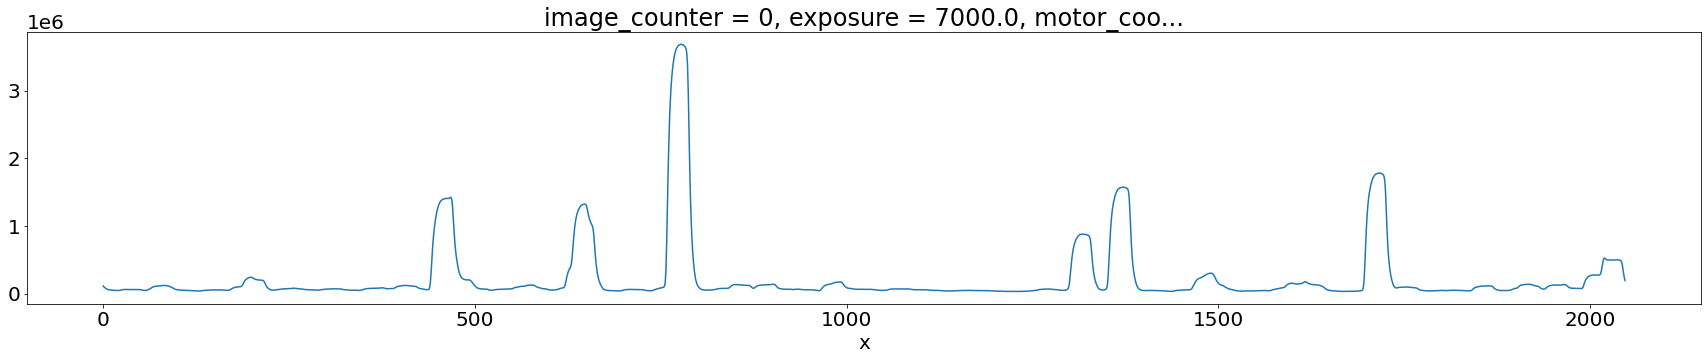

In [156]:
plt.figure(figsize=(30, 5))
spectrum_data.sel(motor_coordinate=455000).plot()
#plt.xlim(0, 310)
#plt.ylim(0, 400000)

Text(0, 0.5, 'wave length (nm)')

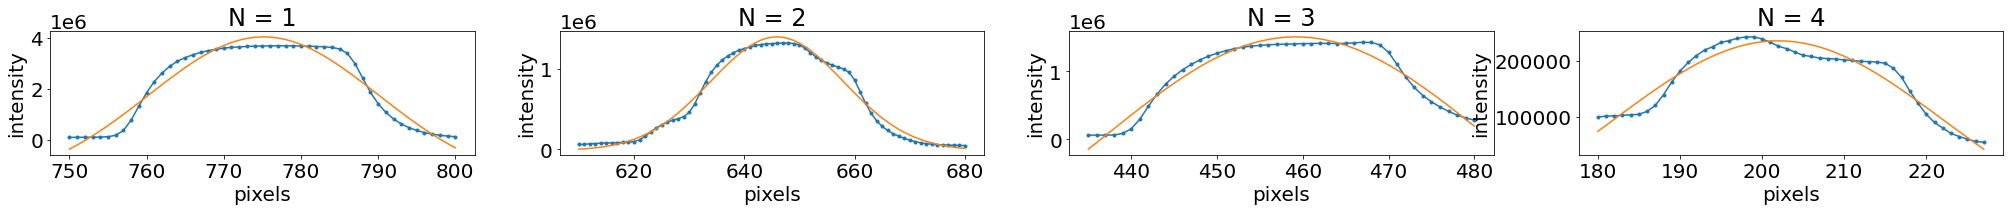

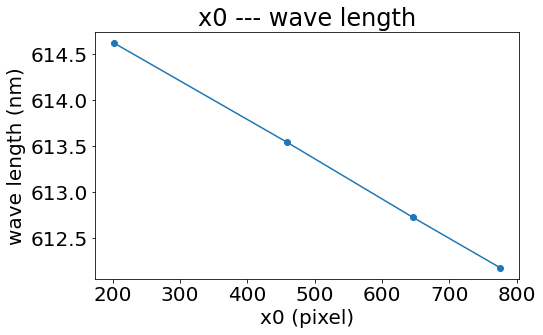

In [157]:
spectrum_lims = [
  [750, 800],
  [610, 680],
  [435, 480],
  [180, 227],
]
wave_lengths = [
  612.1787,
  612.7246,
  613.5395,
  614.6186,
  615.9565
]
plt.figure(figsize=(35, 5))
result_11 = []

for i, lims in enumerate(spectrum_lims):
    result = fit(spectrum_data.sel(motor_coordinate=455000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
    result['v'] = 0
    result['N'] = i+1
    result['wave_length'] = wave_lengths[i]
    result['long_x'] = spectrum_data.sel(motor_coordinate=455000).isel(x=int(result['x0'].values.tolist()))['long_x']
    plt.subplot(2, len(spectrum_lims), i+1)
    result['data'].plot(marker='.')
    result['fit'].plot()
    plt.title('N = {}'.format(i+1))
    plt.xlabel('pixels')
    plt.ylabel('intensity')
    result_11.append(result)
result_11 = xr.concat(result_11, dim='N')

plt.figure(figsize=[35, 10])
plt.subplot(2, i+1, i+2)
plt.plot(result_11['x0'], result_11['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')

## (v' - v") = (2 - 2)

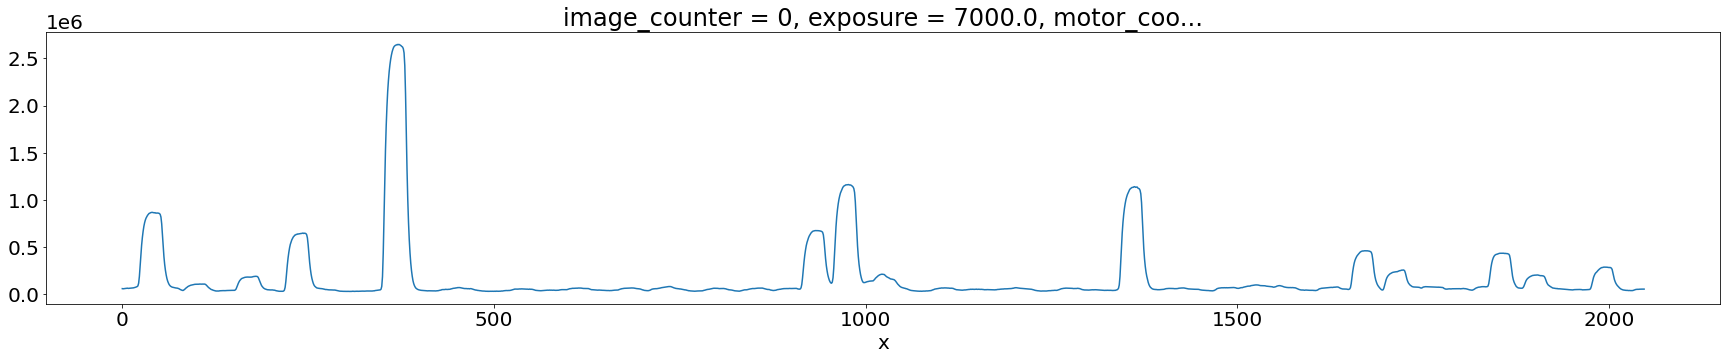

In [158]:
plt.figure(figsize=(30, 5))
spectrum_data.sel(motor_coordinate=445000).plot()
#plt.xlim(0, 310)
#plt.ylim(0, 400000)

Text(0, 0.5, 'wave length (nm)')

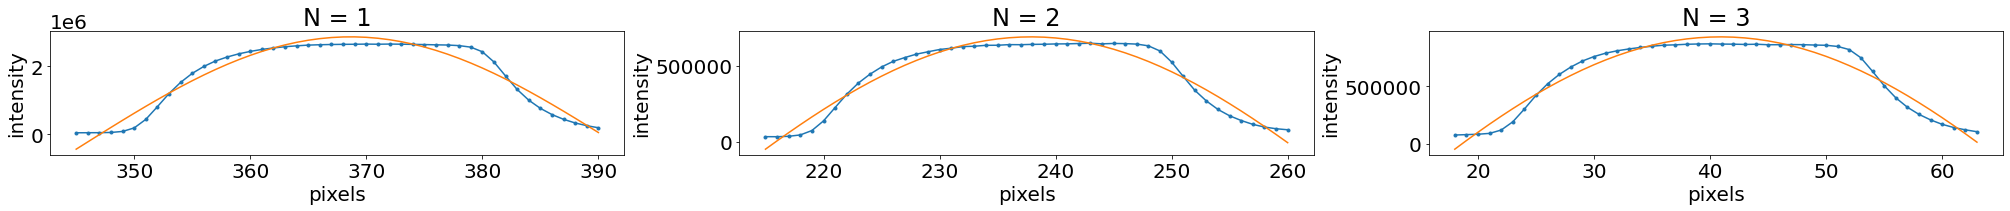

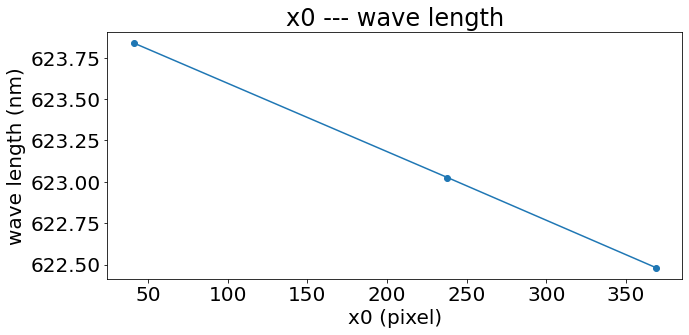

In [159]:
spectrum_lims = [
  [345, 390],
  [215, 260],
  [18, 63],
]
wave_lengths = [
  622.4815,
  623.0258,
  623.8391,
  624.9150,
  626.2495,
  627.8369,
  629.6622,
  631.7233

]
plt.figure(figsize=(35, 5))
result_22 = []

for i, lims in enumerate(spectrum_lims):
    result = fit(spectrum_data.sel(motor_coordinate=445000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
    result['v'] = 0
    result['N'] = i+1
    result['wave_length'] = wave_lengths[i]
    result['long_x'] = spectrum_data.sel(motor_coordinate=445000).isel(x=int(result['x0'].values.tolist()))['long_x']
    plt.subplot(2, len(spectrum_lims), i+1)
    result['data'].plot(marker='.')
    result['fit'].plot()
    plt.title('N = {}'.format(i+1))
    plt.xlabel('pixels')
    plt.ylabel('intensity')
    result_22.append(result)
result_22 = xr.concat(result_22, dim='N')

plt.figure(figsize=[35, 10])
plt.subplot(2, i+1, i+2)
plt.plot(result_22['x0'], result_22['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')

# ピクセルを波長に変換

Text(0, 0.5, 'wavelength (nm)')

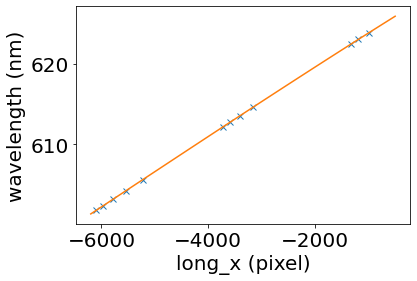

In [160]:
wavelength = np.concatenate([result_00['wave_length'].values, result_11['wave_length'].values, result_22['wave_length'].values])
longx = np.concatenate([result_00['long_x'].values, result_11['long_x'].values, result_22['long_x'].values])

longx_to_wavelength_fun = np.poly1d(np.polyfit(longx, wavelength, 3))
x = np.linspace(-6200, -500, 100)

plt.plot(longx, wavelength, marker='x', linestyle='None')
plt.plot(x, longx_to_wavelength_fun(x))
plt.xlabel('long_x (pixel)')
plt.ylabel('wavelength (nm)')

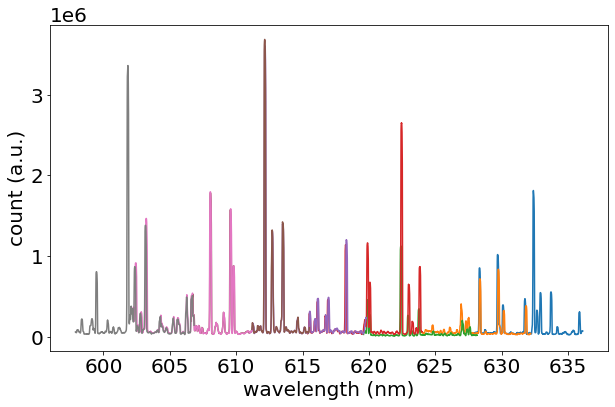

In [161]:
array = []
for a in spectrum_data:
    d = a.assign_coords(wavelength=('x', longx_to_wavelength_fun(a['long_x'])))
    array.append(d)
spectrum_data = xr.concat(array, dim='motor_coordinate')

plt.figure(figsize=(10, 6))
plt.xlabel('wavelength (nm)')
plt.ylabel('count (a.u.)')
for s in spectrum_data:
    plt.plot(s['wavelength'], s)

# 数値積分

## (v' - v") = (0 - 0)

In [162]:
func465000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=465000)['wavelength'], spectrum_data.sel(motor_coordinate=465000), kind='linear')
func460000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=460000)['wavelength'], spectrum_data.sel(motor_coordinate=460000), kind='linear')
func455000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=455000)['wavelength'], spectrum_data.sel(motor_coordinate=455000), kind='linear')
func450000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=450000)['wavelength'], spectrum_data.sel(motor_coordinate=450000), kind='linear')
func445000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=445000)['wavelength'], spectrum_data.sel(motor_coordinate=445000), kind='linear')
func440000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=440000)['wavelength'], spectrum_data.sel(motor_coordinate=440000), kind='linear')
func435000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=435000)['wavelength'], spectrum_data.sel(motor_coordinate=435000), kind='linear')

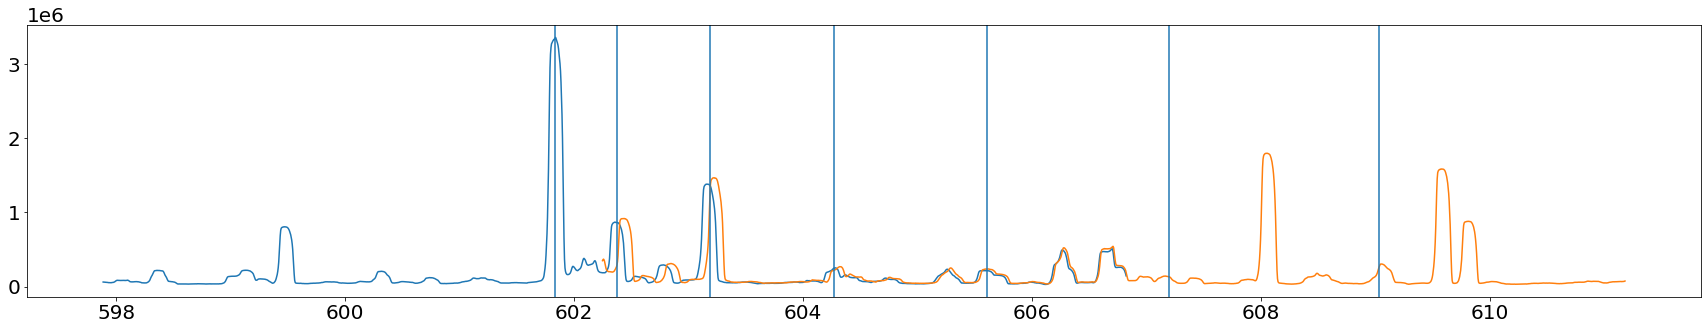

In [163]:
plt.figure(figsize=(30, 5))
data = spectrum_data.sel(motor_coordinate=465000)
plt.plot(data['wavelength'], data)
data = spectrum_data.sel(motor_coordinate=460000)
plt.plot(data['wavelength'], data)
wave_lengths = [
  601.8299,
  602.3757,
  603.1909,
  604.2716,
  605.6091,
  607.1996,
  609.0374,
#  610.9030
]
for w in wave_lengths:
  plt.axvline(w)


In [164]:
array_00 = []
wave_lengths = [
  601.8299,
  602.3757,
  603.1909,
  604.2716,
  605.6091,
  607.1996,
  609.0374,
#  610.9030
]
args = [
  {"func": func465000, "start": 601.73, "end": 601.94, "N": 1},
  {"func": func465000, "start": 602.29, "end": 602.46, "N": 2},
  {"func": func465000, "start": 603.07, "end": 603.275, "N": 3},
  {"func": func465000, "start": 604.17, "end": 604.34, "N": 4},
  {"func": func465000, "start": 605.50, "end": 605.80, "N": 5},
  {"func": func460000, "start": 607.075, "end": 607.28, "N": 6},
  {"func": func460000, "start": 608.92, "end": 609.2, "N": 7},
]

for arg in args:
  array_00.append({
    "v": 0,
    "N": arg['N'],
    "wavelength": wave_lengths[arg['N'] - 1],
    "intensity": integrate.quad(arg['func'], arg['start'], arg['end'])
  })
array_00

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


[{'N': 1,
  'intensity': (420837.700673129, 4.732258417760022),
  'v': 0,
  'wavelength': 601.8299},
 {'N': 2,
  'intensity': (109578.14023834091, 4.575101814465597),
  'v': 0,
  'wavelength': 602.3757},
 {'N': 3,
  'intensity': (176926.7147975614, 1.9312869536224753),
  'v': 0,
  'wavelength': 603.1909},
 {'N': 4,
  'intensity': (32210.88973019045, 0.522924130102183),
  'v': 0,
  'wavelength': 604.2716},
 {'N': 5,
  'intensity': (47883.462543205154, 5.981180885988579),
  'v': 0,
  'wavelength': 605.6091},
 {'N': 6,
  'intensity': (21732.1514630732, 2.8301980920296046),
  'v': 0,
  'wavelength': 607.1996},
 {'N': 7,
  'intensity': (47643.33604266303, 1.486641062401759),
  'v': 0,
  'wavelength': 609.0374}]

## (v' - v") = (1 - 1)

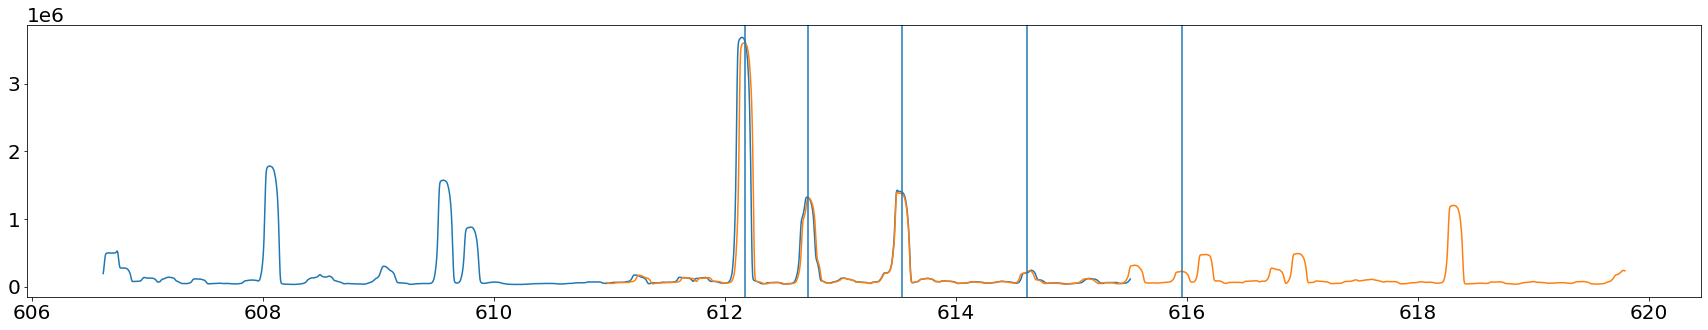

In [165]:
plt.figure(figsize=(30, 5))
data = spectrum_data.sel(motor_coordinate=455000)
plt.plot(data['wavelength'], data)
data = spectrum_data.sel(motor_coordinate=450000)
plt.plot(data['wavelength'], data)
wave_lengths = [
  612.1787,
  612.7246,
  613.5395,
  614.6186,
  615.9565
]
for w in wave_lengths:
  plt.axvline(w)

In [166]:
array_11 = []
wave_lengths = [
  612.1787,
  612.7246,
  613.5395,
  614.6186,
  615.9565
]
args = [
  {"func": func450000, "start": 612.05, "end": 612.27, "N": 1},
  {"func": func450000, "start": 612.6, "end": 612.85, "N": 2},
  {"func": func450000, "start": 613.425, "end": 613.62, "N": 3},
  {"func": func450000, "start": 614.52, "end": 614.75, "N": 4},
  {"func": func450000, "start": 615.85, "end": 616.05, "N": 5},
]

for arg in args:
  array_11.append({
    "v": 1,
    "N": arg['N'],
    "wavelength": wave_lengths[arg['N'] - 1],
    "intensity": integrate.quad(arg['func'], arg['start'], arg['end'])
  })
array_11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


[{'N': 1,
  'intensity': (447258.7257187417, 6.580531082174275),
  'v': 1,
  'wavelength': 612.1787},
 {'N': 2,
  'intensity': (170248.4870335329, 15.531886903714621),
  'v': 1,
  'wavelength': 612.7246},
 {'N': 3,
  'intensity': (181277.8208763541, 21.347555078319996),
  'v': 1,
  'wavelength': 613.5395},
 {'N': 4,
  'intensity': (35426.78332930131, 2.6595725726583623),
  'v': 1,
  'wavelength': 614.6186},
 {'N': 5,
  'intensity': (32689.53424973595, 0.5411823326830927),
  'v': 1,
  'wavelength': 615.9565}]

## (v' - v") = (2 - 2)

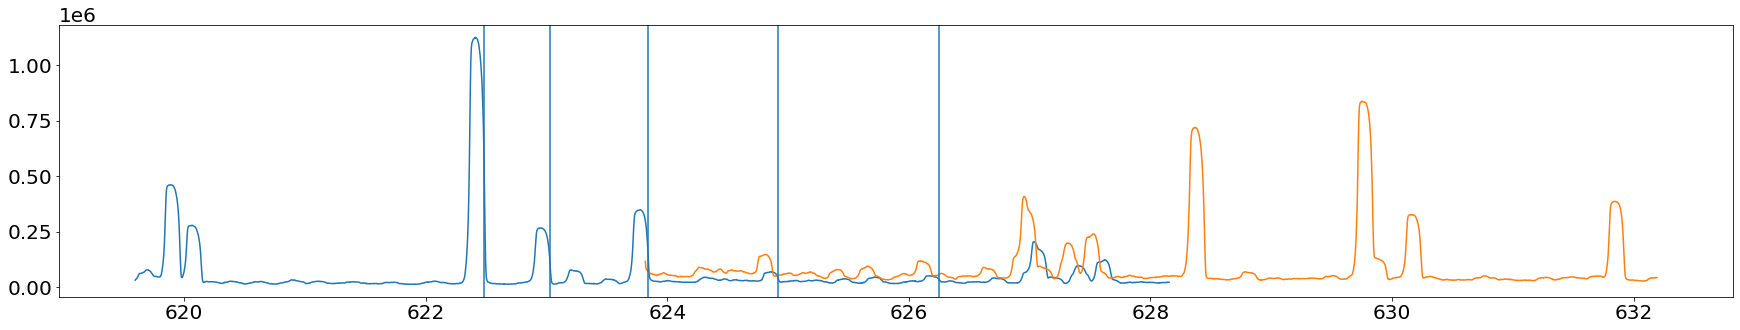

In [167]:
plt.figure(figsize=(30, 5))
data = spectrum_data.sel(motor_coordinate=440000)
plt.plot(data['wavelength'], data)
data = spectrum_data.sel(motor_coordinate=435000)
plt.plot(data['wavelength'], data)
wave_lengths = [
  622.4815,
  623.0258,
  623.8391,
  624.9150,
  626.2495,
#  627.8369,
#  629.6622,
#  631.7233
]
for w in wave_lengths:
  plt.axvline(w)


In [168]:
array_22 = []
wave_lengths = [
  622.4815,
  623.0258,
  623.8391,
  624.9150,
  626.2495,
#  627.8369,
#  629.6622,
#  631.7233
]
args = [
  {"func": func440000, "start": 622.33, "end": 622.52, "N": 1},
  {"func": func440000, "start": 622.86, "end": 623.05, "N": 2},
  {"func": func440000, "start": 623.67, "end": 623.875, "N": 3},
  {"func": func440000, "start": 624.77, "end": 624.93, "N": 4},
  {"func": func440000, "start": 626.1, "end": 626.28, "N": 5},
]

for arg in args:
  array_22.append({
    "v": 2,
    "N": arg['N'],
    "wavelength": wave_lengths[arg['N'] - 1],
    "intensity": integrate.quad(arg['func'], arg['start'], arg['end'])
  })
array_22

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


[{'N': 1,
  'intensity': (136015.44881136497, 4.918736345571233),
  'v': 2,
  'wavelength': 622.4815},
 {'N': 2,
  'intensity': (33196.78688984231, 0.8871012619929388),
  'v': 2,
  'wavelength': 623.0258},
 {'N': 3,
  'intensity': (44305.854632741, 1.2522203651460586),
  'v': 2,
  'wavelength': 623.8391},
 {'N': 4,
  'intensity': (8851.059742525948, 2.0278981062084735),
  'v': 2,
  'wavelength': 624.915},
 {'N': 5,
  'intensity': (7188.620728463713, 0.10313532106374623),
  'v': 2,
  'wavelength': 626.2495}]

# ボルツマンフィッティング

In [169]:
# d状態の回転エネルギー
def e_rot(v, N):
  return ((30.364-1.545*(v+1/2))*N*(N+1)-0.0191*N*(N+1)*N*(N+1))*1.23984/1e4

# 核スピンの縮退度(核スピンの統計重率)
def g_as(N):
  return (N % 2) * 2 + 1

# 回転の統計重率(もしかしたら二乗じゃ無いかも)
def g_N(N):
  return (2*N+1)*(2*N+1)

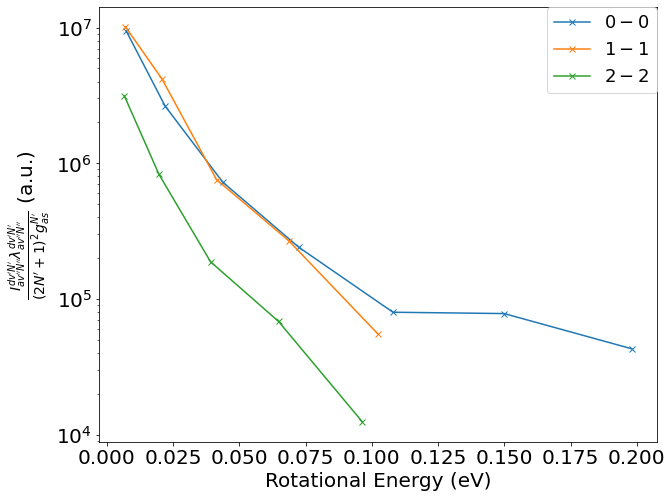

In [170]:
plt.figure(figsize=[10, 8])
plt.rcParams['font.size'] = 20

for d in array_00:
  d['population'] = d['intensity'][0] * d['wavelength'] / g_N(d['N']) / g_as(d['N'])
  d['energy'] = e_rot(d['v'], d['N'])
for d in array_11:
  d['population'] = d['intensity'][0] * d['wavelength'] / g_N(d['N']) / g_as(d['N'])
  d['energy'] = e_rot(d['v'], d['N'])
for d in array_22:
  d['population'] = d['intensity'][0] * d['wavelength'] / g_N(d['N']) / g_as(d['N'])
  d['energy'] = e_rot(d['v'], d['N'])

energy_00 = np.fromiter(map(lambda Q: Q['energy'], array_00), dtype=np.float)
population_00 = np.fromiter(map(lambda Q: Q['population'], array_00), dtype=np.float)
energy_11 = np.fromiter(map(lambda Q: Q['energy'], array_11), dtype=np.float)
population_11 = np.fromiter(map(lambda Q: Q['population'], array_11), dtype=np.float)
energy_22 = np.fromiter(map(lambda Q: Q['energy'], array_22), dtype=np.float)
population_22 = np.fromiter(map(lambda Q: Q['population'], array_22), dtype=np.float)

plt.plot(energy_00, population_00, marker='x', label="$0-0$")
plt.plot(energy_11, population_11, marker='x', label="$1-1$")
plt.plot(energy_22, population_22, marker='x', label="$2-2$")

plt.yscale('log')

plt.xlabel('Rotational Energy (eV)')
plt.ylabel(r"$\frac{I^{dv'N'}_{av''N''}\lambda^{dv'N'}_{av''N''}}{(2N'+1)^2g^{N'}_{as}}$ (a.u.)")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=18)

#plt.savefig(data_path, bbox_inches='tight')

# 上準位回転温度 $T^{dv'}_{rot}$

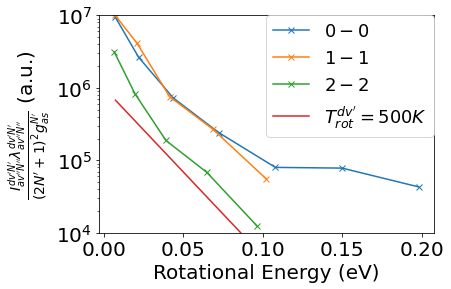

In [172]:
plt.plot(energy_00, population_00, marker='x', label="$0-0$")
plt.plot(energy_11, population_11, marker='x', label="$1-1$")
plt.plot(energy_22, population_22, marker='x', label="$2-2$")

plt.yscale('log')

plt.xlabel('Rotational Energy (eV)')
plt.ylabel(r"$\frac{I^{dv'N'}_{av''N''}\lambda^{dv'N'}_{av''N''}}{(2N'+1)^2g^{N'}_{as}}$ (a.u.)")
plt.ylim(1e4, 1e7)

T_rot = 500 # 上準位の回転温度
const = 6 # 位置合わせのための定数
kb = 8.6171e-5 # [eV K^-1] ボルツマン定数

fit_population_00 = []
for e in energy_00:
  fit_population_00.append(10**(const - e / kb / T_rot))

plt.plot(energy_00, fit_population_00, label="$T^{dv'}_{rot}=500K$")

plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=18)

#plt.savefig(data_path, bbox_inches='tight')